Mammography DICOM data preprocessing examples

- Proper generation of TRAIN/VALID/TEST datasets
- Proper processing of DICOM data


VINDR dataset used as an example

In [1]:
import pandas as pd, numpy as np
import os, shutil
from glob import glob
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style
sns.set(style='dark')

from pydicom import dcmread
from pydicom.dataset import FileDataset

<h2> Proper generation of TRAIN/VALID/TEST datasets </h2>

In [2]:
dataset_dir = os.path.join(
    os.getenv('data_path'),'cbis_ddsm_dicom','manifest-ZkhPvrLo5216730872708713142')

In [52]:
def build_path(folder, file, parent=dataset_dir):
    return os.path.join(dataset_dir,folder,file+".dcm")

In [4]:
df = pd.read_csv(f'{dataset_dir}/metadata.csv')
df.head()

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.9590.100.1.2.174390361112646747718...,CBIS-DDSM,NaN,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,Calc-Test_P_00038_LEFT_MLO,1.3.6.1.4.1.9590.100.1.2.384159464510350889125...,NaN,08-29-2017,full mammogram images,NaN,MG,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,1,28.97 MB,./CBIS-DDSM/Calc-Test_P_00038_LEFT_MLO/08-29-2...,2023-02-01T23:12:54.527
1,1.3.6.1.4.1.9590.100.1.2.419081637812053404913...,CBIS-DDSM,NaN,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,Calc-Test_P_00038_LEFT_CC_1,1.3.6.1.4.1.9590.100.1.2.161465562211359959230...,NaN,08-29-2017,ROI mask images,NaN,MG,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,2,14.06 MB,./CBIS-DDSM/Calc-Test_P_00038_LEFT_CC_1/08-29-...,2023-02-01T23:12:55.085
2,1.3.6.1.4.1.9590.100.1.2.374115997511889073021...,CBIS-DDSM,NaN,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,Calc-Test_P_00038_LEFT_CC,1.3.6.1.4.1.9590.100.1.2.859354343102033567126...,NaN,08-29-2017,full mammogram images,NaN,MG,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,1,27.84 MB,./CBIS-DDSM/Calc-Test_P_00038_LEFT_CC/08-29-20...,2023-02-01T23:12:56.777
3,1.3.6.1.4.1.9590.100.1.2.188613955710170417803...,CBIS-DDSM,NaN,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,Calc-Test_P_00038_LEFT_MLO_1,1.3.6.1.4.1.9590.100.1.2.291121996131431385353...,NaN,08-29-2017,ROI mask images,NaN,MG,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,2,14.62 MB,./CBIS-DDSM/Calc-Test_P_00038_LEFT_MLO_1/08-29...,2023-02-01T23:13:01.032
4,1.3.6.1.4.1.9590.100.1.2.244876997513875090239...,CBIS-DDSM,NaN,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,Calc-Test_P_00038_RIGHT_CC_1,1.3.6.1.4.1.9590.100.1.2.200764632211227648028...,NaN,08-29-2017,ROI mask images,NaN,MG,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,2,13.41 MB,./CBIS-DDSM/Calc-Test_P_00038_RIGHT_CC_1/08-29...,2023-02-01T23:13:01.52


In [77]:
full_mammo = df.loc[df['Series Description'] == 'full mammogram images']

In [50]:
df['file_location'] = df['File Location'].str[2:]

In [5]:
df['File Location'][0]


'./CBIS-DDSM/Calc-Test_P_00038_LEFT_MLO/08-29-2017-DDSM-NA-17613/1.000000-full mammogram images-97934'

In [78]:
subjects = full_mammo['Subject ID'].str.split('_',expand=True)

In [86]:
subjects

,0,1,2,3,4
0,Calc-Test,P,00038,LEFT,MLO
2,Calc-Test,P,00038,LEFT,CC
5,Calc-Test,P,00038,RIGHT,CC
7,Calc-Test,P,00038,RIGHT,MLO
10,Calc-Test,P,00041,LEFT,CC
...,...,...,...,...,...
6763,Mass-Training,P,02033,RIGHT,MLO
6765,Mass-Training,P,02079,RIGHT,MLO
6766,Mass-Training,P,02079,RIGHT,CC
6773,Mass-Training,P,02092,LEFT,CC


<AxesSubplot:>

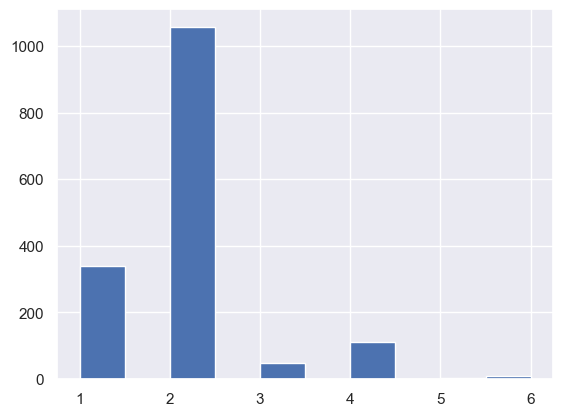

In [89]:
subjects.groupby(2)[1].count().hist()

In [80]:
subjects.loc[subjects[0]=='Calc-Test'][2].drop_duplicates().shape

(151,)

In [81]:
subjects.loc[subjects[0]=='Calc-Training'][2].drop_duplicates().shape

(602,)

In [82]:
subjects.loc[subjects[0]=='Mass-Test'][2].drop_duplicates().shape

(201,)

In [83]:
subjects.loc[subjects[0]=='Mass-Training'][2].drop_duplicates().shape

(691,)

In [84]:
subjects[2].drop_duplicates().shape

(1566,)

In [45]:
subjects.drop_duplicates([0,2]).groupby(2)[0].count().sort_values()

2
00001    1
01292    1
01291    1
01290    1
01288    1
        ..
00652    2
01517    2
01274    2
01502    2
00506    2
Name: 0, Length: 1566, dtype: int64

<h2> Proper processing of DICOM data </h2>

It requires to:
A) process stored pixel data to a original values
B) use observation window to generate an image (pixel) to show on a display or store as a picture format (e.g. JPEG).

Ad. A).
Stored pixel values are typically integer values represented using 2 bytes per pixel. Using PyDicom read we can obtain 16-bits integers. But, in other DICOM attributes (stored in a file) information about data preprocessing could be stored to obtain the proper presentation cotext for data:
- intercept [0x0028, 0x1052], and slope  [0x0028, 0x1053] values could be stored to linearly transform stored pixel value to required presentation values, it. SLOPE * 16_BIT_PIXEL_VALUE + INTERCAPT
- VOI LUT () lookup table could be stored to use this table to map PIXEL VALUES to proper presentation values. In VOI LUT nonlinear transformation could be used (not very often). The related DICOM attributes are: ["(0028, 3000)", "(0028, 3002)", "(0028, 3003)", "(0028, 3004)", "(0028, 3006)"]

So:
1. Check if such attriobutes are defined
2. If so, apply proper transformation to input pixel data.

Ad. B).
Displays or picture file formats use (usually) 8-bits representation per component. In radiology we usually use one-component images (e.g. X-ray attenuation measurement). So input values could be 16bits, but display requires 8-bits for a grayscale image. The originally measure values correspond to tissues properties, so the radiologist can specify the range of values best, to observe tissues properites (e.g. other for bones, another for soft tissues). Therefore, the observation widnow is defined to cut input values to that window range, and then map the cutted input range to 8-bits to produce a grayscale image.

Example:
Range of pixel data: 0 - 2624
Window parameters set in a DICOM file, e.g. Window Center (or Level): 1640, Window Width: 1500
Result: Min: 1640-(1500/2)= 890   Max: 1640+(1500/2)



In [7]:
pixel_min = 0
pixel_max = 2624
wc = 1640
ww = 1500
window_min =  wc-(ww/2)
window_max =  wc+(ww/2)
print(f"Window min: {window_min}, Window max: {window_max}")

# y = ax + b
# 0 = a * window_min + b  -> b = - a * window_min
# 255 = a * window_max + b
# 255 =  a * window_max - a * window_min = a * (window_max-window_min) -> a = 255.0 / (window_max - window_min)


a = 255.0 / (window_max - window_min)
b = - a * window_min

print(f"Scaling factors slope: {a}, intercept: {b}")

scaled_min = int(a * window_min + b)
scaled_max = int(a * window_max + b)
# Use also round or other technique to get int value

print(f"Scaled values:  min: {scaled_min}, Window max: {scaled_max}")

# In PyDICOM we can use predefined properties to get WC/WW and functions to apply it to input data


Window min: 890.0, Window max: 2390.0
Scaling factors slope: 0.17, intercept: -151.3
Scaled values:  min: 0, Window max: 255


In [46]:
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut, apply_windowing

In [47]:
def process_presentation_context(dicom_path: str, debug=False):
    dicom_file = dcmread(dicom_path)
    dcm_pixel_array = dicom_file.pixel_array
    if debug:
        print(f"Min: {np.min(dcm_pixel_array)}, Max: {np.max(dcm_pixel_array)}") 
        wc = dicom_file.WindowCenter
        ww = dicom_file.WindowWidth
        print(f"WL: {wc}, WW: {ww}") 
        vmin = wc - ww/2
        vmax = wc + ww/2 
        print(f"New min: {vmin}, max: {vmax}") 
    img_data = apply_modality_lut(dcm_pixel_array, dicom_file)
    img_data = apply_windowing(img_data, dicom_file)
    return img_data.astype(np.uint16)
    

In [48]:
def show_dcm_image(dicom_path: str, title: str = "dcm img") -> None:
    img_data = process_presentation_context(dicom_path)
    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.axis('off')
    #plt.imshow(dcm_pixel_array, cmap='gray', vmin=vmin, vmax=vmax)
    plt.imshow(img_data, cmap='gray')
    plt.show()

In [49]:
def show_images(dicom_path: str):
    
    img_data_presentation = process_presentation_context(dicom_path)
 
    dicom_file = dcmread(dicom_path)
    img_data_raw = dicom_file.pixel_array
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].imshow(img_data_raw, cmap='gray')
    axes[0].set_title("Image from RAW data")
    axes[1].imshow(img_data_presentation, cmap='gray')
    axes[1].set_title("Image using presentation context")
    fig.tight_layout()

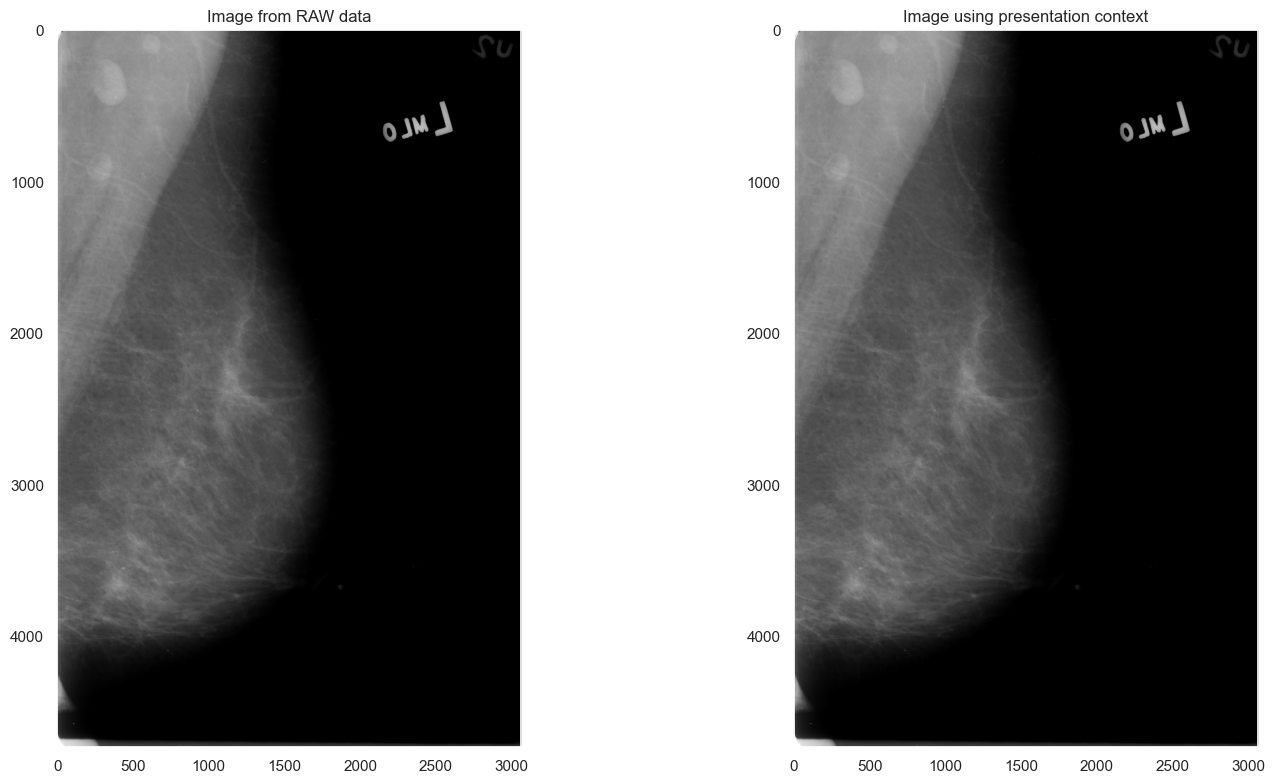

In [53]:
series_example = df['file_location'].iloc[0]
image_example = "1-1"
# show_dcm_image(df['image_path'][0])

dicom_file_to_read = build_path(series_example,image_example)
show_images(dicom_file_to_read)

In [54]:
dicom_file = dcmread(dicom_file_to_read)

In [70]:
dicom_file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.265647748413262733922850405400999282492
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.265647748413262733922850405400999282492
(0008, 0020) Study Date                          DA: ''
(0008, 0023) Content Date     

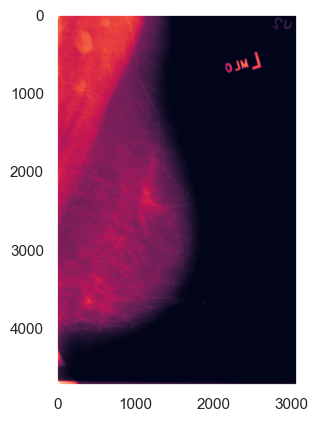

In [68]:
plt.imshow(dicom_file.pixel_array)

Experimental functions to check if presentation attributes are set.

In [13]:
def check_rescale_factors(dicom_source):
    try:
        b_intercept = dicom_source[0x0028, 0x1052]
        if b_intercept is not None:
            print(b_intercept.value)
        else:
            print("1052 None")
            return False
    except:
        return False
    try:
        a_slope = dicom_source[0x0028, 0x1053]
        if a_slope is not None:
            print(a_slope.value)
        else:
            print("1053 None")
            return False
    except:
            return False
    # elem = dicom_source[0x0028, 0x1054]
    # if elem is not None:
    #     print(elem)
    # else:
    #     print("1054 None")
    if b_intercept.value == 0.0 and a_slope.value == 1.0:
        print("No change")
        return False
    
    return True
    
def check_voi_factors(dicom_source):
    #  lut_tags = ["(0028, 3000)", "(0028, 3002)", "(0028, 3003)", "(0028, 3004)", "(0028, 3006)"]
    
    try:
        elem = dicom_source[0x0028, 0x3000]
        if elem is not None:
            print(elem)
        else:
            print("0x3000 None")
    except:
        print("0x3000 None")
    try:
        elem = dicom_source[0x0028, 0x3002]
        if elem is not None:
            print(elem)
        else:
            print("0x3002 None")
    except:
        print("0x3002 None")
    try:
        elem = dicom_source[0x0028, 0x3004]
        if elem is not None:
            print(elem)
        else:
            print("0x3004 None")
    except:
        print("0x3004 None")
    elem = dicom_source[0x0028, 0x3002]
    if elem is not None:
        print(elem.value)
    else:
        print("0x3002 None")
   

In [14]:
data_source =  dcmread(dicom_file_to_read)
check_rescale_factors(data_source)

0
1
No change


False

In [15]:
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut, apply_windowing

# Use the function above to modify pixel data

<h2> Store data as 16-bits PNG images</h2>

Important to process input DICOM files and store pictures in the PNG formsat to use by different models.

In [16]:
from PIL import Image

In [17]:
# PILLOW allows to save data in different formats, e.g.:
# I;16 (16-bit unsigned integer pixels)
# I;16L (16-bit little endian unsigned integer pixels)
# I;16B (16-bit big endian unsigned integer pixels)
# See more at: https://pillow.readthedocs.io/en/stable/handbook/concepts.html

def save_16_bit_png_file(img_data, file_path, debug=False):
    array_buffer = img_data.tobytes()
    if debug:
        print(len(array_buffer))
        print(img_data.T.shape)
    img = Image.new("I", img_data.T.shape)
    img.frombytes(array_buffer, 'raw', "I;16")
    img.save(file_path)

In [18]:
series_example = "00a369b4ec1e5e0ff34e6bd838e5f2d6"
image_example = "f3cbed97f4bb7897467e1e8bab45966e"
# show_dcm_image(df['image_path'][0])

dicom_file_to_read = build_path(series_example,image_example)
img_data_presentation = process_presentation_context(dicom_file_to_read)
print(np.min(img_data_presentation), np.max(img_data_presentation))
print(img_data_presentation.dtype)

save_16_bit_png_file(img_data_presentation, "16_bit_dicom_example.png")

Min: 0, Max: 2624
WL: 1640, WW: 1500
New min: 890.0, max: 2390.0
0 4095
uint16


In [19]:
img_read = Image.open("16_bit_dicom_example.png")
print(img_read.mode)
print(img_read.palette)
print(img_read.format)
print(img_read.size)
arr = np.asarray(img_read)
print(f"Image min: {np.min(arr)}, max: {np.max(arr)}")

I
None
PNG
(2800, 3518)
Image min: 0, max: 4095


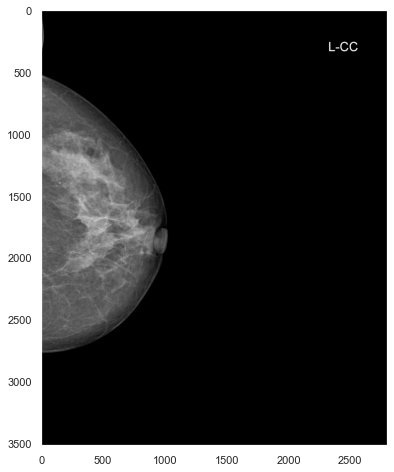

In [20]:
plt.figure(figsize=(8,8))
# plt.axis('off')
#plt.imshow(dcm_pixel_array, cmap='gray', vmin=vmin, vmax=vmax)
plt.imshow(arr, cmap='gray')
plt.show()

In [21]:
def generate_histogram(img, density=True, levels=256):
  
    hist = np.zeros([levels])

    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            pixel = int(img[x, y])
            hist[pixel] += 1

    if density:
        hist /= (img.shape[0] * img.shape[1])
    return hist

(880, 700)
0.0006461038961038961 890 2390


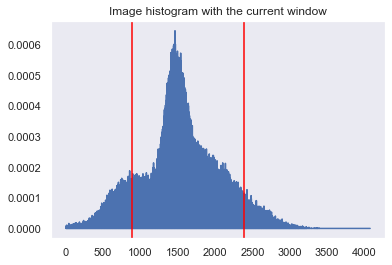

In [22]:
img_copy = arr.copy()
small_arr = img_copy[0::4, 0::4]
print(small_arr.shape)
hist = generate_histogram(small_arr, levels=(np.max(small_arr)+1))
clip = 10
plt.plot(hist[0+clip:len(hist)-clip])

wc = data_source.WindowCenter
ww = data_source.WindowWidth
window_min =  int(wc-(ww/2))
window_max =  int(wc+(ww/2))
print(np.max(hist[0+clip:len(hist)-clip]), window_min, window_max)

plt.axvline(x = window_min, color = 'red')
plt.axvline(x = window_max, color = 'red')
plt.title("Image histogram with the current window")
plt.show()

# plt.hist(gauss.ravel(), bins=(np.max(small_arr)+1), range=(0.0, 255.0), fc='k', ec='k')  # calculating histogram

In [23]:
# Ideas

# 1. to use in the future: starting with the default window, extend it to get XX% of data samples (to use more data)
# 2. to segment breast, then: a) set the backgroud to 0, b) extract best widnow for the breast object, c) (optionally) match histogram of breast object to Gauss

In [24]:
from breast_segment import segment
mask, bbox = segment(arr)

C:\Users\JacekR\AppData\Local\Temp/ipykernel_11140/191373704.py:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  mask, bbox = segment(arr)


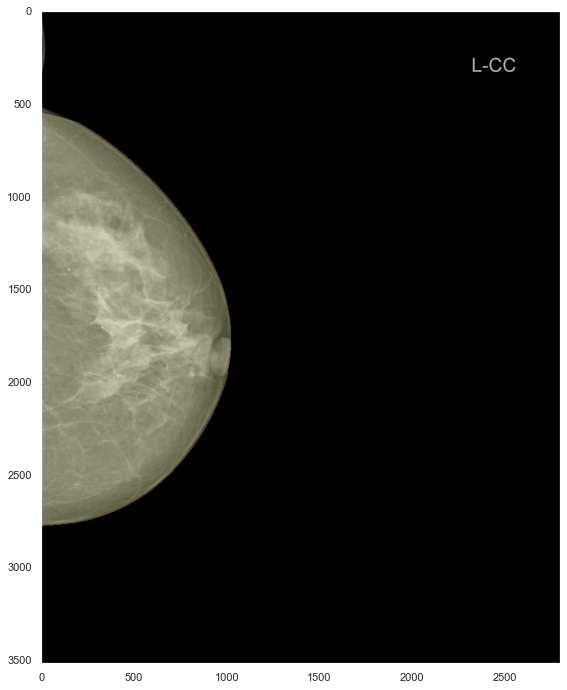

In [25]:
f = plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
ax.imshow(arr, cmap='gray')
ax.imshow(mask, alpha=.3, cmap='inferno') # alpha controls the transparency
plt.show()